# SARIG rock sample lithochemistry load and data clean notebook
In this notebook we explore the very large SARIG geochemistry data package (over 10Gb), extract all the samples that have major element geochemistry and then clean that data ready for the protolith modelling app. We then extract the matching lithology records to use as validation in the following lithology prediction notebook.

Because of the size of the initial dataset, we use the dask library to parallelise the processing of the data until we can get it to a manageable size. The Pyrolite library is a great tool for manipulating geochemical data and is used to transform elements to oxides and do Fe conversions.

The SARIG Data Package is an extract from the Geological Survey of South Australia’s (GSSA) geoscientific database SA Geodata. SA Geodata is the primary repository for geoscientific information in South Australia and contains data collected: from research and fieldwork conducted by GSSA staff; by mineral exploration companies who are required to submit most of the data they collect during their exploration programs to the state government, and; data collected by research institutions from analysis of core and rock samples held in the South Australian Core Library. This snapshot of the database was provided for the ExploreSA: Gawler Challenge and is valid as at Feburary 2020.

In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import seaborn as sns

import pyrolite.comp
import pyrolite.geochem 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)
pd.set_option('precision',3)

%matplotlib inline

## Load the dataset, check col headers and the numbers of different sample types 

In [2]:
ddf = dd.read_csv(r'D:\Unearthed_SARIG_Data_Package\SARIG_Data_Package\sarig_rs_chem_exp.csv',dtype={'LITHO_CONF': 'object',
       'STRAT_CONF': 'object'})

In [3]:
ddf.columns

Index(['SAMPLE_NO', 'SAMPLE_SOURCE_CODE', 'SAMPLE_SOURCE', 'ROCK_GROUP_CODE',
       'ROCK_GROUP', 'LITHO_CODE', 'LITHO_CONF', 'LITHOLOGY_NAME',
       'LITHO_MODIFIER', 'MAP_SYMBOL', 'STRAT_CONF', 'STRAT_NAME',
       'COLLECTED_BY', 'COLLECTORS_NUMBER', 'COLLECTED_DATE',
       'DRILLHOLE_NUMBER', 'DH_NAME', 'DH_DEPTH_FROM', 'DH_DEPTH_TO',
       'SITE_NO', 'EASTING_GDA2020', 'NORTHING_GDA2020', 'ZONE_GDA2020',
       'LONGITUDE_GDA2020', 'LATITUDE_GDA2020', 'LONGITUDE_GDA94',
       'LATITUDE_GDA94', 'SAMPLE_ANALYSIS_NO', 'OTHER_ANALYSIS_ID',
       'ANALYSIS_TYPE_DESC', 'LABORATORY', 'CHEM_CODE', 'VALUE', 'UNIT',
       'CHEM_METHOD_CODE', 'CHEM_METHOD_DESC'],
      dtype='object')

In [7]:
ddf.head(10)

,SAMPLE_NO,SAMPLE_SOURCE_CODE,SAMPLE_SOURCE,ROCK_GROUP_CODE,ROCK_GROUP,LITHO_CODE,LITHO_CONF,LITHOLOGY_NAME,LITHO_MODIFIER,MAP_SYMBOL,STRAT_CONF,STRAT_NAME,COLLECTED_BY,COLLECTORS_NUMBER,COLLECTED_DATE,DRILLHOLE_NUMBER,DH_NAME,DH_DEPTH_FROM,DH_DEPTH_TO,SITE_NO,EASTING_GDA2020,NORTHING_GDA2020,ZONE_GDA2020,LONGITUDE_GDA2020,LATITUDE_GDA2020,LONGITUDE_GDA94,LATITUDE_GDA94,SAMPLE_ANALYSIS_NO,OTHER_ANALYSIS_ID,ANALYSIS_TYPE_DESC,LABORATORY,CHEM_CODE,VALUE,UNIT,CHEM_METHOD_CODE,CHEM_METHOD_DESC
0,589,RO,Rock outcrop / float,SSA,Sediment Siliciclastic Arenite,SDST,NaN,Sandstone,NaN,NaN,NaN,NaN,"MIRAMS, R.C.",600/1,13/12/1960,NaN,NaN,NaN,NaN,128096,513602.61,7.006e+06,52,129.137,-27.070,129.137,-27.070,158,NaN,GEOCHEMISTRY,NaN,Ti,0.15,%,AES,AES
1,589,RO,Rock outcrop / float,SSA,Sediment Siliciclastic Arenite,SDST,NaN,Sandstone,NaN,NaN,NaN,NaN,"MIRAMS, R.C.",600/1,13/12/1960,NaN,NaN,NaN,NaN,128096,513602.61,7.006e+06,52,129.137,-27.070,129.137,-27.070,158,NaN,GEOCHEMISTRY,NaN,Ag,500,ppb,AES,AES
2,589,RO,Rock outcrop / float,SSA,Sediment Siliciclastic Arenite,SDST,NaN,Sandstone,NaN,NaN,NaN,NaN,"MIRAMS, R.C.",600/1,13/12/1960,NaN,NaN,NaN,NaN,128096,513602.61,7.006e+06,52,129.137,-27.070,129.137,-27.070,158,NaN,GEOCHEMISTRY,NaN,Ba,1200,ppm,AES,AES
3,589,RO,Rock outcrop / float,SSA,Sediment Siliciclastic Arenite,SDST,NaN,Sandstone,NaN,NaN,NaN,NaN,"MIRAMS, R.C.",600/1,13/12/1960,NaN,NaN,NaN,NaN,128096,513602.61,7.006e+06,52,129.137,-27.070,129.137,-27.070,158,NaN,GEOCHEMISTRY,NaN,Co,2,ppm,AES,AES
4,589,RO,Rock outcrop / float,SSA,Sediment Siliciclastic Arenite,SDST,NaN,Sandstone,NaN,NaN,NaN,NaN,"MIRAMS, R.C.",600/1,13/12/1960,NaN,NaN,NaN,NaN,128096,513602.61,7.006e+06,52,129.137,-27.070,129.137,-27.070,158,NaN,GEOCHEMISTRY,NaN,Cr,1000,ppm,AES,AES
5,589,RO,Rock outcrop / float,SSA,Sediment Siliciclastic Arenite,SDST,NaN,Sandstone,NaN,NaN,NaN,NaN,"MIRAMS, R.C.",600/1,13/12/1960,NaN,NaN,NaN,NaN,128096,513602.61,7.006e+06,52,129.137,-27.070,129.137,-27.070,158,NaN,GEOCHEMISTRY,NaN,Cu,8,ppm,AES,AES
6,589,RO,Rock outcrop / float,SSA,Sediment Siliciclastic Arenite,SDST,NaN,Sandstone,NaN,NaN,NaN,NaN,"MIRAMS, R.C.",600/1,13/12/1960,NaN,NaN,NaN,NaN,128096,513602.61,7.006e+06,52,129.137,-27.070,129.137,-27.070,158,NaN,GEOCHEMISTRY,NaN,Pb,5,ppm,AES,AES
7,589,RO,Rock outcrop / float,SSA,Sediment Siliciclastic Arenite,SDST,NaN,Sandstone,NaN,NaN,NaN,NaN,"MIRAMS, R.C.",600/1,13/12/1960,NaN,NaN,NaN,NaN,128096,513602.61,7.006e+06,52,129.137,-27.070,129.137,-27.070,158,NaN,GEOCHEMISTRY,NaN,V,12,ppm,AES,AES
8,589,RO,Rock outcrop / float,SSA,Sediment Siliciclastic Arenite,SDST,NaN,Sandstone,NaN,NaN,NaN,NaN,"MIRAMS, R.C.",600/1,13/12/1960,NaN,NaN,NaN,NaN,128096,513602.61,7.006e+06,52,129.137,-27.070,129.137,-27.070,158,NaN,GEOCHEMISTRY,NaN,Zn,<20,ppm,AES,AES
9,590,RO,Rock outcrop / float,IMI,Igneous Mafic Intrusive,GBRO,NaN,Gabbro,"massive, medium grained",MN,NaN,Mesoproterozoic-Neoproterozoic rocks,"MIRAMS, R.C.",600/3,13/12/1960,NaN,NaN,NaN,NaN,128097,534985.64,7.007e+06,52,129.353,-27.061,129.353,-27.061,160,NaN,GEOCHEMISTRY,NaN,Ti,0.5,%,AES,AES


In [4]:
ddf['SAMPLE_SOURCE'].value_counts().compute()

Drill cuttings                                                  10956887
Sawn half drill core                                             7256976
Drill core                                                       6533477
Calcrete                                                         2154614
Soil                                                              989296
Drilled interval rock sample, type unspecified                    970508
Rock outcrop / float                                              537537
Sawn quarter drill core                                           237103
Drillhole log data - used in calculating values                   212746
Stream sediment                                                   164251
Auger sample from near surface                                    105514
Vegetation                                                         71018
Core sludge                                                        56217
A full face slice of core                          

Select only samples from rock sample types, excluding things like soils, lag and excrement of animals!

In [6]:
ddf_rock_sample = ddf[ddf['SAMPLE_SOURCE'].isin(['Drill cuttings','Sawn half drill core','Drill core','Drilled interval rock sample, type unspecified','Rock outcrop / float','Sawn quarter drill core','Drillhole log data - used in calculating values','A full face slice of core','Pulp / powdered rock of known origin, typically a lab return','Duplicate: a split from an existing sample.','Channel (linear rock chip/outcrop sampling)','Rock outcrop sample','Costean (trench)','Filleted, shaved or ground core sample','Rock float sample (not in situ)','Drillhole','Rock subcrop sample (in situ, not attached to bedrock)'])]

Generate a list of unique SAMPLE_ANALYSIS_NO that contain data for the required major elements

In [8]:
elements = ['SiO2','Al2O3','TiO2','Fe2O3','MgO','CaO','Na2O','K2O','P2O5','LOI','LOI_minus','LOI_plus','FeO']
analyses = ddf_rock_sample[ddf_rock_sample.CHEM_CODE.isin(elements)].SAMPLE_ANALYSIS_NO.unique()

Compute a pandas dataframe for the unique SAMPLE_ANALYSIS_NO with the required chemical data cols and a second df for the lithological data linked to the SAMPLE_ANALYSIS_NO

In [9]:
ddf_major_chem = ddf_rock_sample[ddf_rock_sample.SAMPLE_ANALYSIS_NO.isin(list(analyses))][['SAMPLE_NO','SAMPLE_ANALYSIS_NO',"CHEM_CODE",'VALUE','UNIT','ANALYSIS_TYPE_DESC','CHEM_METHOD_CODE','OTHER_ANALYSIS_ID','ANALYSIS_TYPE_DESC','COLLECTED_DATE']].drop_duplicates()

df_major_chem = ddf_major_chem.compute()

In [10]:
df_lithologies = ddf_rock_sample[ddf_rock_sample.SAMPLE_ANALYSIS_NO.isin(list(analyses))][['SAMPLE_ANALYSIS_NO','ROCK_GROUP_CODE','ROCK_GROUP', 'LITHO_CODE', 'LITHOLOGY_NAME', 'MAP_SYMBOL','STRAT_NAME']].drop_duplicates().compute()

In [11]:
df_major_chem.sort_values('SAMPLE_ANALYSIS_NO')

,SAMPLE_NO,SAMPLE_ANALYSIS_NO,CHEM_CODE,VALUE,UNIT,ANALYSIS_TYPE_DESC,CHEM_METHOD_CODE,OTHER_ANALYSIS_ID,ANALYSIS_TYPE_DESC,COLLECTED_DATE
164510,506,122,Rb,75,ppm,GEOCHEMISTRY,XRF,NaN,GEOCHEMISTRY,25/07/1966
164513,506,122,Zr,120,ppm,GEOCHEMISTRY,XRF,NaN,GEOCHEMISTRY,25/07/1966
164512,506,122,Y,20,ppm,GEOCHEMISTRY,XRF,NaN,GEOCHEMISTRY,25/07/1966
164511,506,122,Sr,100,ppm,GEOCHEMISTRY,XRF,NaN,GEOCHEMISTRY,25/07/1966
98784,506,122,Cr,30,ppm,GEOCHEMISTRY,AAS,NaN,GEOCHEMISTRY,25/07/1966
...,...,...,...,...,...,...,...,...,...,...
175132,2968524,2476035,Ce,30.5,ppm,GEOCHEMISTRY,ME-XRF21n,NaN,GEOCHEMISTRY,28/06/2012
155934,2968524,2476035,LOI,0.74,%,GEOCHEMISTRY,ME-GRA05,NaN,GEOCHEMISTRY,28/06/2012
175133,2968524,2476035,Co,3,ppm,GEOCHEMISTRY,ME-XRF21n,NaN,GEOCHEMISTRY,28/06/2012
175127,2968524,2476035,As,2.5,ppm,GEOCHEMISTRY,ME-XRF21n,NaN,GEOCHEMISTRY,28/06/2012


If we look at an example sample we can see that this dataframe contains the major elements we want plus extras. It also has duplicate analytes analysed by different methods

In [13]:
df_major_chem[df_major_chem['SAMPLE_ANALYSIS_NO']==2466083]

,SAMPLE_NO,SAMPLE_ANALYSIS_NO,CHEM_CODE,VALUE,UNIT,ANALYSIS_TYPE_DESC,CHEM_METHOD_CODE,OTHER_ANALYSIS_ID,ANALYSIS_TYPE_DESC,COLLECTED_DATE
147316,2958572,2466083,Ga,30,ppm,GEOCHEMISTRY,ME-MS62s,NaN,GEOCHEMISTRY,31/05/2012
147317,2958572,2466083,La,26.5,ppm,GEOCHEMISTRY,ME-MS62s,NaN,GEOCHEMISTRY,31/05/2012
147318,2958572,2466083,Mo,0.5,ppm,GEOCHEMISTRY,ME-MS62s,NaN,GEOCHEMISTRY,31/05/2012
147319,2958572,2466083,Ni,24,ppm,GEOCHEMISTRY,ME-MS62s,NaN,GEOCHEMISTRY,31/05/2012
147320,2958572,2466083,P,600,ppm,GEOCHEMISTRY,ME-MS62s,NaN,GEOCHEMISTRY,31/05/2012
147321,2958572,2466083,P2O5,0.137,%,GEOCHEMISTRY,ME-MS62s,NaN,GEOCHEMISTRY,31/05/2012
147322,2958572,2466083,Pb,4,ppm,GEOCHEMISTRY,ME-MS62s,NaN,GEOCHEMISTRY,31/05/2012
147323,2958572,2466083,S,0.01,%,GEOCHEMISTRY,ME-MS62s,NaN,GEOCHEMISTRY,31/05/2012
147324,2958572,2466083,Sb,2.5,ppm,GEOCHEMISTRY,ME-MS62s,NaN,GEOCHEMISTRY,31/05/2012
147325,2958572,2466083,Sc,8,ppm,GEOCHEMISTRY,ME-MS62s,NaN,GEOCHEMISTRY,31/05/2012


Create a new dataframe with only the required elements for the protolith prediction app. Here we include both oxides and elements as we can convert all to oxides at a later point. 

In [24]:
elements2 = ['SiO2','Al2O3','TiO2','Fe2O3','MgO','CaO','Na2O','K2O','P2O5','LOI','FeO','Si','Al','Ti','Fe','Mg','Ca','Na','K','P']
df_major_elements = df_major_chem[df_major_chem['CHEM_CODE'].isin(elements2)]

In [17]:
df_major_elements[df_major_elements['SAMPLE_ANALYSIS_NO']==2466083]

,SAMPLE_NO,SAMPLE_ANALYSIS_NO,CHEM_CODE,VALUE,UNIT,ANALYSIS_TYPE_DESC,CHEM_METHOD_CODE,OTHER_ANALYSIS_ID,ANALYSIS_TYPE_DESC,COLLECTED_DATE
147320,2958572,2466083,P,600,ppm,GEOCHEMISTRY,ME-MS62s,NaN,GEOCHEMISTRY,31/05/2012
147321,2958572,2466083,P2O5,0.137,%,GEOCHEMISTRY,ME-MS62s,NaN,GEOCHEMISTRY,31/05/2012
147329,2958572,2466083,Ti,0.19,%,GEOCHEMISTRY,ME-MS62s,NaN,GEOCHEMISTRY,31/05/2012
17613,2958572,2466083,Al2O3,12.9,%,GEOCHEMISTRY,ME-MS41,NaN,GEOCHEMISTRY,31/05/2012
17615,2958572,2466083,CaO,2.39,%,GEOCHEMISTRY,ME-MS41,NaN,GEOCHEMISTRY,31/05/2012
17616,2958572,2466083,K2O,5.05,%,GEOCHEMISTRY,ME-MS41,NaN,GEOCHEMISTRY,31/05/2012
17617,2958572,2466083,MgO,10.2,%,GEOCHEMISTRY,ME-MS41,NaN,GEOCHEMISTRY,31/05/2012
17618,2958572,2466083,Na2O,0.217,%,GEOCHEMISTRY,ME-MS41,NaN,GEOCHEMISTRY,31/05/2012
17619,2958572,2466083,SiO2,53.8,%,GEOCHEMISTRY,ME-MS41,NaN,GEOCHEMISTRY,31/05/2012
31119,2958572,2466083,Al,7.05,%,GEOCHEMISTRY,ME-XRF21n,NaN,GEOCHEMISTRY,31/05/2012


To check on some of the duplicated analytes we look for duplicate CHEM_CODE and SAMPLE_ANALYSIS_NO fields. In the head of that table below we can see that some are complete duplicate analyses while others are the same values added as both wt% and ppm. We also have some elements in as both oxides and elements by different methods.

In [31]:
dup_analysis_samples = df_major_chem[df_major_chem.duplicated(subset=['SAMPLE_ANALYSIS_NO','CHEM_CODE'],keep=False)].sort_values(['SAMPLE_ANALYSIS_NO','CHEM_CODE']) 

In [32]:
dup_analysis_samples.head(30)

,SAMPLE_NO,SAMPLE_ANALYSIS_NO,CHEM_CODE,VALUE,UNIT,ANALYSIS_TYPE_DESC,CHEM_METHOD_CODE,OTHER_ANALYSIS_ID,ANALYSIS_TYPE_DESC,COLLECTED_DATE
164713,969,776,Al2O3,21.36,%,GEOCHEMISTRY,XRF,NaN,GEOCHEMISTRY,23/11/1984
164724,969,776,Al2O3,24.87,%,GEOCHEMISTRY,XRF,NaN,GEOCHEMISTRY,23/11/1984
164719,969,776,CaO,12.16,%,GEOCHEMISTRY,XRF,NaN,GEOCHEMISTRY,23/11/1984
164730,969,776,CaO,12.86,%,GEOCHEMISTRY,XRF,NaN,GEOCHEMISTRY,23/11/1984
164715,969,776,Fe2O3,2.38,%,GEOCHEMISTRY,XRF,NaN,GEOCHEMISTRY,23/11/1984
164726,969,776,Fe2O3,0.57,%,GEOCHEMISTRY,XRF,NaN,GEOCHEMISTRY,23/11/1984
164716,969,776,FeO,3.84,%,GEOCHEMISTRY,XRF,NaN,GEOCHEMISTRY,23/11/1984
164727,969,776,FeO,4.94,%,GEOCHEMISTRY,XRF,NaN,GEOCHEMISTRY,23/11/1984
164721,969,776,K2O,0.12,%,GEOCHEMISTRY,XRF,NaN,GEOCHEMISTRY,23/11/1984
164732,969,776,K2O,0.2,%,GEOCHEMISTRY,XRF,NaN,GEOCHEMISTRY,23/11/1984


In [33]:
dup_analysis_samples[dup_analysis_samples['SAMPLE_ANALYSIS_NO']==2466083]

,SAMPLE_NO,SAMPLE_ANALYSIS_NO,CHEM_CODE,VALUE,UNIT,ANALYSIS_TYPE_DESC,CHEM_METHOD_CODE,OTHER_ANALYSIS_ID,ANALYSIS_TYPE_DESC,COLLECTED_DATE
31129,2958572,2466083,Fe,6.27,%,GEOCHEMISTRY,ME-XRF21n,NaN,GEOCHEMISTRY,31/05/2012
116464,2958572,2466083,Fe,6.43,%,GEOCHEMISTRY,ME-ICP61,NaN,GEOCHEMISTRY,31/05/2012


To handle these duplicate analyses we create a new dataframe and drop one of the duplicate analyses 

In [34]:
df_major_elements_tmp1 = df_major_elements.sort_values(['SAMPLE_ANALYSIS_NO','CHEM_CODE','CHEM_METHOD_CODE']).drop_duplicates(subset=['SAMPLE_ANALYSIS_NO','CHEM_CODE'],keep='last')

Our subset major element data now consists of about 3 million individual analyses. But the data is not all numeric and contins a number of other symbols such as < and -. We need to find what non-numeric symbols there are and then remove. Need to note that the < symbol is the deliminator for analyses below detection limit. In this case to handle BDL values we will replace the DL value with half of the reported detection limit.

In [35]:
df_major_elements_tmp1['UNIT'].value_counts()

%      2979740
ppm     227117
ppb       1083
g/T         13
Name: UNIT, dtype: int64

In [36]:
sym_find_list = [re.findall(r'\D', str(i)) for i in df_major_elements_tmp1['VALUE']]
unique_symbols = set([item for sublist in sym_find_list for item in sublist])
unique_symbols

{'-', '.', '<', '>'}

In [37]:
df_major_elements_tmp1.drop(df_major_elements_tmp1[df_major_elements_tmp1['VALUE'].str.contains('>',na=False, regex=False)].index, inplace=True)

In [39]:
df_major_elements_tmp1[df_major_elements_tmp1['VALUE'].str.contains(r'-',na=False,regex=False)].tail()

,SAMPLE_NO,SAMPLE_ANALYSIS_NO,CHEM_CODE,VALUE,UNIT,ANALYSIS_TYPE_DESC,CHEM_METHOD_CODE,OTHER_ANALYSIS_ID,ANALYSIS_TYPE_DESC,COLLECTED_DATE
14320,1703219,1692890,LOI,-0.32,%,GEOCHEMISTRY,LOI,562.0/0910907,GEOCHEMISTRY,05/10/2009
14334,1703221,1692892,LOI,-0.16,%,GEOCHEMISTRY,LOI,562.0/0910907,GEOCHEMISTRY,05/10/2009
16070,1703222,1692893,LOI,-0.35,%,GEOCHEMISTRY,LOI,562.0/0910907,GEOCHEMISTRY,05/10/2009
95053,2457789,1988166,LOI,<0-10,%,GEOCHEMISTRY,XRF78S,WM111749,GEOCHEMISTRY,07/10/2008
59340,2458844,1989221,LOI,<0-10,%,GEOCHEMISTRY,XRF78S,WM111749,GEOCHEMISTRY,11/09/2008


In [40]:
df_major_elements_tmp1.loc[df_major_elements_tmp1['VALUE'] == '<0-10','VALUE'] = '<-10'

In [41]:
df_major_elements_tmp1[df_major_elements_tmp1['VALUE'].str.contains(r'<',na=False,regex=False)].tail()

,SAMPLE_NO,SAMPLE_ANALYSIS_NO,CHEM_CODE,VALUE,UNIT,ANALYSIS_TYPE_DESC,CHEM_METHOD_CODE,OTHER_ANALYSIS_ID,ANALYSIS_TYPE_DESC,COLLECTED_DATE
120332,2888479,2397678,CaO,<0.001,%,GEOCHEMISTRY,ME-XRF11b,NaN,GEOCHEMISTRY,10/07/2010
120379,2888480,2397679,Al2O3,<0.001,%,GEOCHEMISTRY,ME-XRF11b,NaN,GEOCHEMISTRY,10/07/2010
120432,2888483,2397682,CaO,<0.001,%,GEOCHEMISTRY,ME-XRF11b,NaN,GEOCHEMISTRY,10/07/2010
120457,2888484,2397683,CaO,<0.001,%,GEOCHEMISTRY,ME-XRF11b,NaN,GEOCHEMISTRY,10/07/2010
110845,2917716,2425228,LOI,<0.1,%,GEOCHEMISTRY,ME-GRA05,NaN,GEOCHEMISTRY,17/10/2011


In [42]:
# create a flag column to identify BDL values
df_major_elements_tmp1['BDL'] = 0
df_major_elements_tmp1.loc[df_major_elements_tmp1['VALUE'].str.contains('<',na=False,regex=False), 'BDL'] = 1


In [43]:
# remove < in vlues col
df_major_elements_tmp1['VALUE'] = df_major_elements_tmp1['VALUE'].astype(str).str.replace("<", "").astype(float)

In [44]:
#convert BDL units to half reported limit
df_major_elements_tmp1.loc[df_major_elements_tmp1['BDL'] == 1,'VALUE'] = df_major_elements_tmp1.loc[df_major_elements_tmp1['BDL'] == 1,'VALUE'] /2

In [34]:
df_major_elements_tmp1['UNIT'].value_counts()

%      2977164
ppm     226943
ppb       1082
g/T         13
Name: UNIT, dtype: int64

Checking the absolute value of some of the analyses, it's clear that there are petentially some mislabeled units on a number of the analytes. For example on the below search for SiO2 VALUE below 110 we have a bunch of recent analyses using XRF which have SiO2 values reported as ppm. In the cell below that if we look at one of those samples we can see that there is a variety of oxides reported as either ppm, ppb or % with values that would be generally equivilent to wt% oxide values. Looking at these data, the rocks are highly altred and won't give totals near 100% for the majors anyway. In the cell below that we see some other examples of true elemental ppm values, this group of samples also have oxide values which will be used as the primary major element. 

In [53]:
df_major_elements_tmp1.loc[(df_major_elements_tmp1['VALUE'] < 110) & (df_major_elements_tmp1['UNIT']=='ppm') & (df_major_elements_tmp1['CHEM_CODE']=='SiO2')]

,SAMPLE_NO,SAMPLE_ANALYSIS_NO,CHEM_CODE,VALUE,UNIT,ANALYSIS_TYPE_DESC,CHEM_METHOD_CODE,OTHER_ANALYSIS_ID,ANALYSIS_TYPE_DESC,COLLECTED_DATE,BDL
181133,646950,280519,SiO2,27.50,ppm,GEOCHEMISTRY,XRF,NaN,GEOCHEMISTRY,19/10/1981,0
171109,2665686,2190620,SiO2,57.71,ppm,GEOCHEMISTRY,XRF4B,NaN,GEOCHEMISTRY,13/01/2012,0
171124,2665687,2190621,SiO2,34.51,ppm,GEOCHEMISTRY,XRF4B,NaN,GEOCHEMISTRY,13/01/2012,0
171139,2665688,2190622,SiO2,31.16,ppm,GEOCHEMISTRY,XRF4B,NaN,GEOCHEMISTRY,13/01/2012,0
171154,2665689,2190623,SiO2,26.68,ppm,GEOCHEMISTRY,XRF4B,NaN,GEOCHEMISTRY,13/01/2012,0
...,...,...,...,...,...,...,...,...,...,...,...
167316,2667211,2192108,SiO2,10.27,ppm,GEOCHEMISTRY,XRF4B,NaN,GEOCHEMISTRY,30/06/2017,0
167328,2667212,2192109,SiO2,39.05,ppm,GEOCHEMISTRY,XRF4B,NaN,GEOCHEMISTRY,30/06/2017,0
167340,2667213,2192110,SiO2,36.03,ppm,GEOCHEMISTRY,XRF4B,NaN,GEOCHEMISTRY,30/06/2017,0
167352,2667214,2192111,SiO2,8.28,ppm,GEOCHEMISTRY,XRF4B,NaN,GEOCHEMISTRY,30/06/2017,0


In [54]:
df_major_elements_tmp1[df_major_elements_tmp1['SAMPLE_ANALYSIS_NO'] == 2190621]

,SAMPLE_NO,SAMPLE_ANALYSIS_NO,CHEM_CODE,VALUE,UNIT,ANALYSIS_TYPE_DESC,CHEM_METHOD_CODE,OTHER_ANALYSIS_ID,ANALYSIS_TYPE_DESC,COLLECTED_DATE,BDL
171114,2665687,2190621,Al2O3,11.380,ppm,GEOCHEMISTRY,XRF4B,NaN,GEOCHEMISTRY,13/01/2012,0
171115,2665687,2190621,CaO,1.040,ppm,GEOCHEMISTRY,XRF4B,NaN,GEOCHEMISTRY,13/01/2012,0
171117,2665687,2190621,Fe,29.350,ppb,GEOCHEMISTRY,XRF4B,NaN,GEOCHEMISTRY,13/01/2012,0
171118,2665687,2190621,K2O,0.140,%,GEOCHEMISTRY,XRF4B,NaN,GEOCHEMISTRY,13/01/2012,0
36607,2665687,2190621,LOI,9.260,ppm,GEOCHEMISTRY,TG001,NaN,GEOCHEMISTRY,13/01/2012,0
171119,2665687,2190621,MgO,0.270,ppm,GEOCHEMISTRY,XRF4B,NaN,GEOCHEMISTRY,13/01/2012,0
171121,2665687,2190621,Na2O,0.050,ppm,GEOCHEMISTRY,XRF4B,NaN,GEOCHEMISTRY,13/01/2012,0
171122,2665687,2190621,P,0.011,ppm,GEOCHEMISTRY,XRF4B,NaN,GEOCHEMISTRY,13/01/2012,0
171124,2665687,2190621,SiO2,34.510,ppm,GEOCHEMISTRY,XRF4B,NaN,GEOCHEMISTRY,13/01/2012,0
171126,2665687,2190621,TiO2,0.820,ppm,GEOCHEMISTRY,XRF4B,NaN,GEOCHEMISTRY,13/01/2012,0


In [46]:
df_major_elements_tmp1.loc[(df_major_elements_tmp1['VALUE'] < 90) & (df_major_elements_tmp1['UNIT']=='ppm')]

,SAMPLE_NO,SAMPLE_ANALYSIS_NO,CHEM_CODE,VALUE,UNIT,ANALYSIS_TYPE_DESC,CHEM_METHOD_CODE,OTHER_ANALYSIS_ID,ANALYSIS_TYPE_DESC,COLLECTED_DATE,BDL
150847,14774,8903,P,60.0,ppm,GEOCHEMISTRY,IC3,NaN,GEOCHEMISTRY,07/02/1992,0
21141,8972,10248,Ti,14.0,ppm,GEOCHEMISTRY,NaN,NaN,GEOCHEMISTRY,11/04/1975,0
21170,8976,10250,Ti,18.0,ppm,GEOCHEMISTRY,NaN,NaN,GEOCHEMISTRY,04/02/1976,0
21198,8977,10252,Ti,16.0,ppm,GEOCHEMISTRY,NaN,NaN,GEOCHEMISTRY,04/02/1976,0
21226,8978,10254,Ti,18.0,ppm,GEOCHEMISTRY,NaN,NaN,GEOCHEMISTRY,04/02/1976,0
...,...,...,...,...,...,...,...,...,...,...,...
73384,2968519,2476030,P,20.0,ppm,GEOCHEMISTRY,ME-MS62s,NaN,GEOCHEMISTRY,28/06/2012,0
73482,2968521,2476032,P,10.0,ppm,GEOCHEMISTRY,ME-MS62s,NaN,GEOCHEMISTRY,28/06/2012,0
73499,2968522,2476033,P,20.0,ppm,GEOCHEMISTRY,ME-MS62s,NaN,GEOCHEMISTRY,28/06/2012,0
73449,2968523,2476034,P,30.0,ppm,GEOCHEMISTRY,ME-MS62s,NaN,GEOCHEMISTRY,28/06/2012,0


In [55]:
df_major_elements_tmp1[df_major_elements_tmp1['SAMPLE_ANALYSIS_NO'] == 10248]

,SAMPLE_NO,SAMPLE_ANALYSIS_NO,CHEM_CODE,VALUE,UNIT,ANALYSIS_TYPE_DESC,CHEM_METHOD_CODE,OTHER_ANALYSIS_ID,ANALYSIS_TYPE_DESC,COLLECTED_DATE,BDL
21139,8972,10248,Al2O3,15.26,%,GEOCHEMISTRY,NaN,NaN,GEOCHEMISTRY,11/04/1975,0
21146,8972,10248,CaO,1.19,%,GEOCHEMISTRY,NaN,NaN,GEOCHEMISTRY,11/04/1975,0
21142,8972,10248,Fe2O3,0.87,%,GEOCHEMISTRY,NaN,NaN,GEOCHEMISTRY,11/04/1975,0
21143,8972,10248,FeO,0.60,%,GEOCHEMISTRY,NaN,NaN,GEOCHEMISTRY,11/04/1975,0
21148,8972,10248,K2O,5.10,%,GEOCHEMISTRY,NaN,NaN,GEOCHEMISTRY,11/04/1975,0
21145,8972,10248,MgO,0.23,%,GEOCHEMISTRY,NaN,NaN,GEOCHEMISTRY,11/04/1975,0
21147,8972,10248,Na2O,3.97,%,GEOCHEMISTRY,NaN,NaN,GEOCHEMISTRY,11/04/1975,0
21149,8972,10248,P2O5,0.03,%,GEOCHEMISTRY,NaN,NaN,GEOCHEMISTRY,11/04/1975,0
21138,8972,10248,SiO2,71.24,%,GEOCHEMISTRY,NaN,NaN,GEOCHEMISTRY,11/04/1975,0
21141,8972,10248,Ti,14.00,ppm,GEOCHEMISTRY,NaN,NaN,GEOCHEMISTRY,11/04/1975,0


Below we correct these potential mislabeled units 

In [56]:
# convrt all values to wt% if value above 150 (assume values below are mislabeled as ppm when should be wt%)
df_major_elements_tmp1.loc[(df_major_elements_tmp1['VALUE'] > 150) & (df_major_elements_tmp1['UNIT']=='ppm') , 'VALUE'] = df_major_elements_tmp1.loc[(df_major_elements_tmp1['VALUE'] > 150) & (df_major_elements_tmp1['UNIT']=='ppm') , 'VALUE'] /10000

df_major_elements_tmp1.loc[(df_major_elements_tmp1['VALUE'] > 150) & (df_major_elements_tmp1['UNIT']=='g/T') , 'VALUE'] = df_major_elements_tmp1.loc[(df_major_elements_tmp1['VALUE'] > 150) & (df_major_elements_tmp1['UNIT']=='g/T') , 'VALUE'] /10000


Now we convert the cleaned chemical data from long format to a tidydata wide format, and convert datatypes from object to float

In [57]:
df_major_chem_wide = df_major_elements_tmp1.pivot(index='SAMPLE_ANALYSIS_NO', values=['VALUE'],columns='CHEM_CODE').sort_values('CHEM_CODE',axis=1)

In [58]:
df_major_chem_wide.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321523 entries, 122 to 2476035
Data columns (total 20 columns):
(VALUE, Al)       159011 non-null float64
(VALUE, Al2O3)    189183 non-null float64
(VALUE, Ca)       161617 non-null float64
(VALUE, CaO)      189758 non-null float64
(VALUE, Fe)       261640 non-null float64
(VALUE, Fe2O3)    61647 non-null float64
(VALUE, FeO)      4665 non-null float64
(VALUE, K)        161452 non-null float64
(VALUE, K2O)      186116 non-null float64
(VALUE, LOI)      156535 non-null float64
(VALUE, Mg)       160007 non-null float64
(VALUE, MgO)      190418 non-null float64
(VALUE, Na)       177231 non-null float64
(VALUE, Na2O)     171249 non-null float64
(VALUE, P)        258112 non-null float64
(VALUE, P2O5)     211858 non-null float64
(VALUE, Si)       1600 non-null float64
(VALUE, SiO2)     192035 non-null float64
(VALUE, Ti)       159448 non-null float64
(VALUE, TiO2)     151620 non-null float64
dtypes: float64(20)
memory usage: 61.5 MB


In [59]:
df_major_chem_wide.tail(5)

VALUE                                                  \
CHEM_CODE             Al  Al2O3    Ca   CaO    Fe Fe2O3 FeO     K    K2O   
SAMPLE_ANALYSIS_NO                                                         
2476031             6.62  13.55  0.25  0.36  0.97   NaN NaN  1.09  1.435   
2476032             6.66  13.50  0.24  0.33  0.69   NaN NaN  2.40  3.050   
2476033             5.74  11.60  0.23  0.34  1.11   NaN NaN  1.27  1.685   
2476034             6.55  13.00  0.38  0.53  0.95   NaN NaN  0.99  1.300   
2476035             6.74  13.75  0.57  0.82  0.59   NaN NaN  1.48  1.890   

                                                                          \
CHEM_CODE            LOI    Mg   MgO    Na  Na2O      P   P2O5  Si  SiO2   
SAMPLE_ANALYSIS_NO                                                         
2476031             0.45  0.33  0.65  4.11  6.29   0.03  0.069 NaN  75.7   
2476032             0.39  0.15  0.28  3.51  5.35  10.00  0.002 NaN  76.0   
2476033             0.45  0.21  0.40  3.32  5.11  20.00  0.005 NaN  78.7   
2476034             0.53  0.19  0.39  4.17  6.25  30.00  0.007 NaN  75.2   
2476035             0.74  0.13  0.25  4.24  6.41  20.00  0.005 NaN  74.6   

                               
CHEM_CODE             Ti TiO2  
SAMPLE_ANALYSIS_NO             
2476031             0.01  NaN  
2476032             0.01  NaN  
2476033             0.01  NaN  
2476034             0.02  NaN  
2476035             0.01  NaN

Make a copy of the new wide table to flatten headers

In [60]:
df_major_chem_wide_temp1 = df_major_chem_wide.copy()
df_major_chem_wide_temp1.columns = ['Al','Al2O3','Ca','CaO','Fe','Fe2O3','FeO','K','K2O','LOI','Mg','MgO','Na','Na2O','P','P2O5','Si','SiO2','Ti','TiO2']

In [61]:
df_major_chem_wide_temp1.head()

,Al,Al2O3,Ca,CaO,Fe,Fe2O3,FeO,K,K2O,LOI,Mg,MgO,Na,Na2O,P,P2O5,Si,SiO2,Ti,TiO2
SAMPLE_ANALYSIS_NO,,,,,,,,,,,,,,,,,,,,
122,NaN,14.5,NaN,8.55,NaN,11.10,NaN,NaN,1.39,1.25,NaN,4.62,NaN,2.26,NaN,0.09,NaN,55.5,NaN,0.84
124,NaN,14.9,NaN,8.95,NaN,10.30,NaN,NaN,1.38,1.85,NaN,4.86,NaN,2.10,NaN,0.07,NaN,55.0,NaN,0.85
126,NaN,14.9,NaN,5.95,NaN,11.10,NaN,NaN,2.18,2.28,NaN,5.20,NaN,4.26,NaN,0.09,NaN,53.7,NaN,0.85
128,NaN,15.9,NaN,8.70,NaN,8.40,NaN,NaN,1.32,4.42,NaN,4.24,NaN,2.08,NaN,0.09,NaN,54.4,NaN,0.90
130,NaN,18.6,NaN,3.80,NaN,1.94,NaN,NaN,6.45,3.44,NaN,1.08,NaN,2.18,NaN,0.02,NaN,60.8,NaN,1.06


Next we convert the elemental data where it exists of oxides and append it to the measured oxide data. We then check for where there is no primary oxide data and supplement it with the converted elemental to oxide data and create a final oxides dataframe.

In [62]:
eles_to_ox = df_major_chem_wide_temp1.pyrochem.elements.pyrochem.convert_chemistry(to=['Al2O3','CaO','Fe2O3','K2O','MgO','Na2O','P2O5','SiO2','TiO2'])

In [63]:
eles_to_ox.columns = [str(col) + '_ele' for col in eles_to_ox.columns]

In [65]:
df_major_chem_wide_temp2 = pd.concat([wide_chem_ox,eles_to_ox],axis=1)

In [66]:
df_major_chem_wide_temp2.head()

,Al2O3,CaO,Fe2O3,FeO,K2O,LOI,MgO,Na2O,P2O5,SiO2,TiO2,Al2O3_ele,CaO_ele,Fe2O3_ele,K2O_ele,MgO_ele,Na2O_ele,P2O5_ele,SiO2_ele,TiO2_ele
SAMPLE_ANALYSIS_NO,,,,,,,,,,,,,,,,,,,,
122,14.5,8.55,11.10,NaN,1.39,1.25,4.62,2.26,0.09,55.5,0.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,14.9,8.95,10.30,NaN,1.38,1.85,4.86,2.10,0.07,55.0,0.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126,14.9,5.95,11.10,NaN,2.18,2.28,5.20,4.26,0.09,53.7,0.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,15.9,8.70,8.40,NaN,1.32,4.42,4.24,2.08,0.09,54.4,0.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,18.6,3.80,1.94,NaN,6.45,3.44,1.08,2.18,0.02,60.8,1.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
ox = ['Al2O3', 'CaO', 'Fe2O3', 'K2O', 'MgO', 'Na2O', 'P2O5', 'SiO2', 'TiO2']
el = ['Al2O3_ele', 'CaO_ele', 'Fe2O3_ele', 'K2O_ele', 'MgO_ele', 'Na2O_ele', 'P2O5_ele', 'SiO2_ele', 'TiO2_ele']

for o,e in zip(ox,el):
    df_major_chem_wide_temp2.loc[(df_major_chem_wide_temp2[o].isnull()) & (df_major_chem_wide_temp2[e].notnull()),o] = df_major_chem_wide_temp2[e]

In [68]:
df_major_chem_wide_temp3 = df_major_chem_wide_temp2[['Al2O3', 'CaO', 'Fe2O3','FeO', 'K2O','LOI','MgO', 'Na2O', 'P2O5', 'SiO2', 'TiO2']]

In [69]:
df_major_chem_wide_temp3

,Al2O3,CaO,Fe2O3,FeO,K2O,LOI,MgO,Na2O,P2O5,SiO2,TiO2
SAMPLE_ANALYSIS_NO,,,,,,,,,,,
122,14.50,8.55,11.100,NaN,1.390,1.25,4.62,2.26,0.090,55.5,0.840
124,14.90,8.95,10.300,NaN,1.380,1.85,4.86,2.10,0.070,55.0,0.850
126,14.90,5.95,11.100,NaN,2.180,2.28,5.20,4.26,0.090,53.7,0.850
128,15.90,8.70,8.400,NaN,1.320,4.42,4.24,2.08,0.090,54.4,0.900
130,18.60,3.80,1.940,NaN,6.450,3.44,1.08,2.18,0.020,60.8,1.060
...,...,...,...,...,...,...,...,...,...,...,...
2476031,13.55,0.36,1.387,NaN,1.435,0.45,0.65,6.29,0.069,75.7,0.017
2476032,13.50,0.33,0.987,NaN,3.050,0.39,0.28,5.35,0.002,76.0,0.017
2476033,11.60,0.34,1.587,NaN,1.685,0.45,0.40,5.11,0.005,78.7,0.017


Then we check the oxide totals to make sure they are resonable and drop samples that are highly altered or that have incorrect values, with totals outside of the 90-105% range 

In [70]:
#check totals 
df_major_chem_wide_temp3['Totals'] = df_major_chem_wide_temp3.sum(axis=1)

In [85]:
df_major_chem_wide_temp4 = df_major_chem_wide_temp3.drop(df_major_chem_wide_temp3[~df_major_chem_wide_temp3['Totals'].between(90,105)].index).drop('Totals',axis=1)

Then we devolatolise the samples to recalculate majors as anhydrous, and convert all Fe2O3 to FeO for the protolith app. Finally we drop any samples with missing values to have the final cleaned major element dataset 

In [86]:
df_major_chem_wide_temp5 = df_major_chem_wide_temp4.pyrochem.devolatilise(exclude=['LOI'],renorm=True)

In [89]:
df_major_chem_wide_temp6 = df_major_chem_wide_temp5.pyrochem.recalculate_Fe(to='FeO',renorm=True)

In [90]:
df_major_chem_wide_temp6.head(10)

,Al2O3,CaO,FeO,K2O,MgO,Na2O,P2O5,SiO2,TiO2
SAMPLE_ANALYSIS_NO,,,,,,,,,
122,14.836,8.748,10.219,1.422,4.727,2.312,0.092,56.785,0.859
124,15.301,9.191,9.518,1.417,4.991,2.157,0.072,56.481,0.873
126,15.342,6.127,10.284,2.245,5.354,4.386,0.093,55.294,0.875
128,16.704,9.140,7.940,1.387,4.454,2.185,0.095,57.150,0.945
130,19.429,3.969,1.823,6.737,1.128,2.277,0.021,63.508,1.107
773,22.500,8.665,4.696,0.447,4.185,4.226,0.010,55.047,0.223
774,0.654,4.839,0.342,0.000,10.055,0.764,NaN,55.769,27.577
775,26.061,10.068,3.034,0.451,2.066,4.091,0.010,54.048,0.170
776,24.258,12.544,5.319,0.195,4.292,3.794,0.010,49.209,0.380


In [91]:
majors = df_major_chem_wide_temp6.dropna()

In [92]:
majors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159376 entries, 122 to 2476035
Data columns (total 9 columns):
Al2O3    159376 non-null float64
CaO      159376 non-null float64
FeO      159376 non-null float64
K2O      159376 non-null float64
MgO      159376 non-null float64
Na2O     159376 non-null float64
P2O5     159376 non-null float64
SiO2     159376 non-null float64
TiO2     159376 non-null float64
dtypes: float64(9)
memory usage: 17.2 MB


## In the following section we select the lithology info for the samples based on the SAMPLE_ANALYSIS_NO's in the major elements dataframe and join to create the final dataset for modelling 

In [93]:
df_lithologies[df_lithologies['ROCK_GROUP_CODE'].notnull()].sample(5)

,SAMPLE_ANALYSIS_NO,ROCK_GROUP_CODE,ROCK_GROUP,LITHO_CODE,LITHOLOGY_NAME,MAP_SYMBOL,STRAT_NAME
149958,183643,IFI,Igneous Felsic Intrusive,GRNT,Granite,Mncv,Mount Victoria Granite
134263,38529,IFI,Igneous Felsic Intrusive,MCGR,Microgranite,Mh,Hiltaba Suite
114220,1696069,MIM,Meta-Igneous Mafic,MMIG,Meta-Mafic Igneous Rock,Lz,Peter Pan Supersuite
30159,18814,SSL,Sediment Siliciclastic Lutite,SLST,Siltstone,Ndsg,Glen Osmond Slate Member
62144,1474758,IMI,Igneous Mafic Intrusive,GBRO,Gabbro,Lp,St Peter Suite


In [94]:
major_sample_list = list(majors.index)
rock_groups_tags = df_lithologies[df_lithologies['SAMPLE_ANALYSIS_NO'].isin(major_sample_list)][['SAMPLE_ANALYSIS_NO','ROCK_GROUP','LITHOLOGY_NAME']].set_index('SAMPLE_ANALYSIS_NO')
# checkthe shapes of the df's to make sure we have the same lengths
print(majors.shape)
print(rock_groups_tags.shape)

(159376, 9)
(159376, 2)


In [95]:
# Create the final tagged dataset by joiningon index
majors_tagged = majors.join(rock_groups_tags)
majors_tagged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159376 entries, 122 to 2476035
Data columns (total 11 columns):
Al2O3             159376 non-null float64
CaO               159376 non-null float64
FeO               159376 non-null float64
K2O               159376 non-null float64
MgO               159376 non-null float64
Na2O              159376 non-null float64
P2O5              159376 non-null float64
SiO2              159376 non-null float64
TiO2              159376 non-null float64
ROCK_GROUP        10422 non-null object
LITHOLOGY_NAME    10422 non-null object
dtypes: float64(9), object(2)
memory usage: 19.6+ MB


Export the final dataset 

In [96]:
majors_tagged.to_csv(r'D:\Python ML\SA-geology-lith-predictions\data\SARIG_major_els_v1.csv')

## Finally we can quickly visualise the distribution of the final dataset. 

You can see from this that there is a very long tail on the FeO analyses. These probably represent mineralised or highly altered samples as can be seen in the table below with the labled data. The samples with hifh FeO and low SiO2 are either mineralised samples or are high grade metamorphic rocks that are probably melt depleted, or metamorphosed Fe formations   

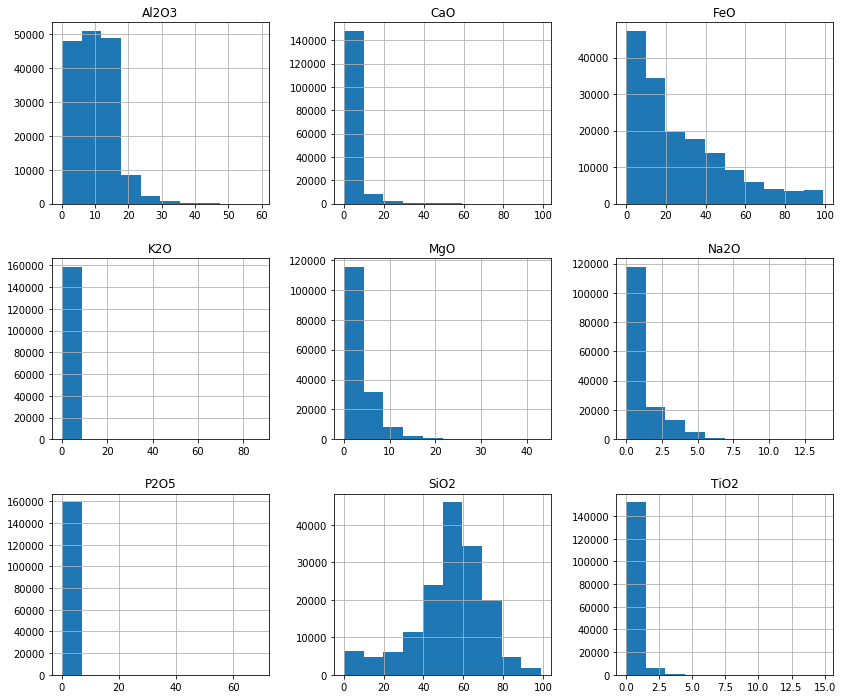

In [97]:
majors.hist(figsize = (14,12))
plt.show()

In [98]:
majors_tagged.loc[(majors_tagged['FeO'] > 50) & (majors_tagged['SiO2'] < 40) & (majors_tagged.ROCK_GROUP.notnull())].sample(50)

,Al2O3,CaO,FeO,K2O,MgO,Na2O,P2O5,SiO2,TiO2,ROCK_GROUP,LITHOLOGY_NAME
SAMPLE_ANALYSIS_NO,,,,,,,,,,,
1618503,0.198,0.070,84.357,0.012,0.070,0.035,0.070,15.013,0.175,Mineralised Rock/Ore Metallic,Metallic Mineralised Rock/Ore
1683296,0.089,0.190,93.741,0.011,0.034,0.034,0.017,5.817,0.067,Metasomatic/Thermal/Hydrothermal,Ironstone (Metasomatic)
1683264,0.318,2.161,91.827,0.011,0.592,0.033,1.382,3.653,0.022,Metasomatic/Thermal/Hydrothermal,Magnetite-Rich Rock (Metasomatic)
1618513,0.431,0.155,83.306,0.033,0.077,0.132,0.044,15.668,0.155,Mineralised Rock/Ore Metallic,Metallic Mineralised Rock/Ore
1618474,0.277,0.012,92.190,0.012,0.012,0.127,0.017,6.800,0.554,Mineralised Rock/Ore Metallic,Metallic Mineralised Rock/Ore
1540735,7.618,3.139,54.169,2.543,4.501,0.911,0.563,26.151,0.405,Metasediment,Metasediment
1618514,0.114,0.148,84.983,0.011,0.034,0.034,0.068,14.493,0.114,Mineralised Rock/Ore Metallic,Metallic Mineralised Rock/Ore
1618481,0.178,0.048,85.817,0.012,0.024,0.048,0.059,13.684,0.131,Mineralised Rock/Ore Metallic,Metallic Mineralised Rock/Ore
1683253,0.436,1.036,94.365,0.011,0.839,0.076,0.120,2.889,0.229,Metasomatic/Thermal/Hydrothermal,Magnetite-Rich Rock (Metasomatic)
